# Modulation Transfer Function

The modulation transfer function is defined as the FFT of the point spread function. The point spread function is defined as the derivative of the edge spread function. The edge spread function are the values along an edge.

Since FT of a function is complex, the MTF should have magnitude and phase response as a function of spatial frequency, similar to transfer functions of control systems. However, it is often sufficient to look at the magnitude response to get a measure of the resolution of the system.

Pattern size: 200 by 355 mm

In [322]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, glob, skimage, random
from PIL import Image
from skimage import measure
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1

import warnings
warnings.filterwarnings("ignore")

## Import images
Convert RGB to grayscale to remove unwanted bias and noise on the image samples.

In [110]:
def batch_import(source_dir):
    imgs = []
    img_files = glob.glob(str(source_dir) + "/*.png")
    for img in img_files:
        samp = cv2.imread(img)
        samp = samp[:,:,::-1] # reverse color channels
        gray_img = cv2.cvtColor(samp, cv2.COLOR_BGR2GRAY)
        imgs.append(gray_img)

    return np.array(imgs)

In [108]:
def jpg2png(source_dir):
    jpgimgs = glob.glob(str(source_dir) + "/*.jpg")
    for imgs in jpgimgs:
        img = cv2.imread(imgs)
        cv2.imwrite(imgs[:-3] + "png", img)

In [111]:
sample_imgs = batch_import("Sample Images")

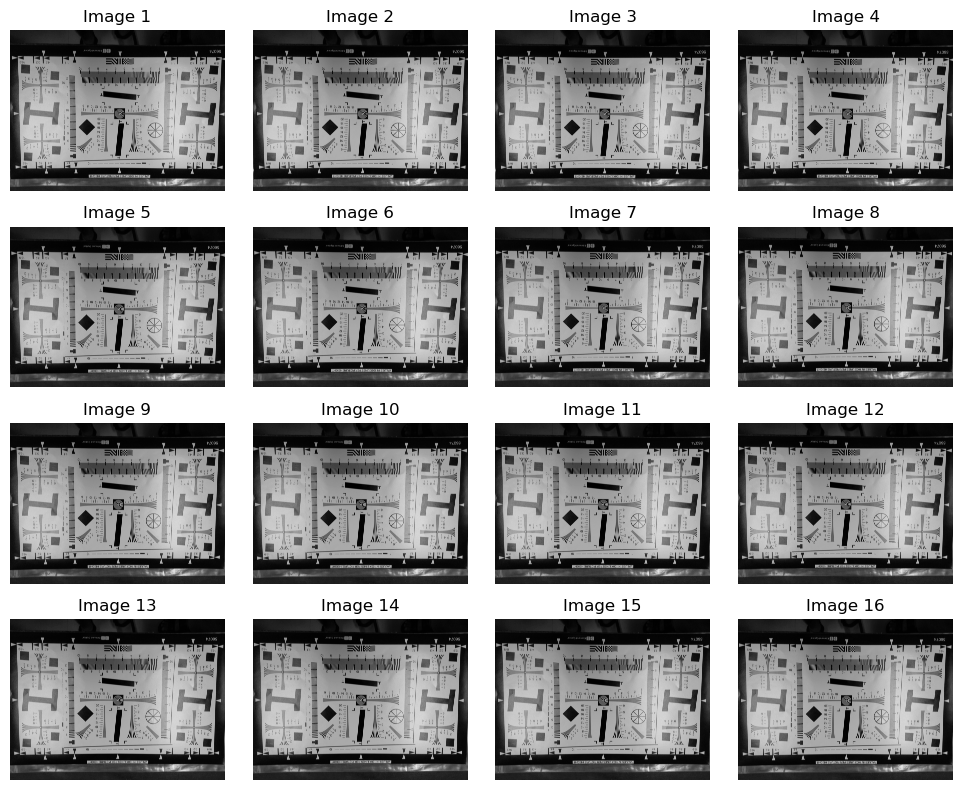

In [112]:
fig, ax = plt.subplots(4, 4, figsize = (16, 8), tight_layout = True)
plt.subplots_adjust(wspace = -0.8)
ax = ax.flatten()
    
for i, img in enumerate(sample_imgs[0:16]):
    ax[i].imshow(img, cmap = "gray")
    ax[i].set_title("Image {}".format(i+1))
    ax[i].axis("off")

## Averaging burst images
Capture several images of the test chart using your camera under test. If your camera can do burst, then use it. Take the average of the images so that noise on the flat parts are minimized. If your camera does not have burst, make sure you register or align your images accurately before averaging.

In [113]:
# Average grayscale pixel value image
gray_img_pixel_sum = np.zeros(shape = (np.shape(sample_imgs)[1], np.shape(sample_imgs)[2]))

for img in sample_imgs[11:15,:,:]:
    gray_img_pixel_sum += img
    
average_gray_img = gray_img_pixel_sum / np.shape(sample_imgs)[0]

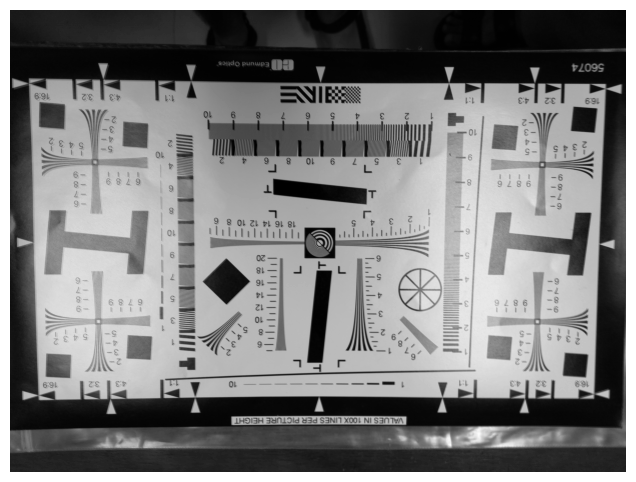

In [114]:
plt.figure(figsize = (12, 6))
plt.imshow(average_gray_img, cmap = "gray")
plt.axis("off")
plt.imsave("Average grayscale image.png", average_gray_img, cmap = "gray")

## Edge profiles and linespread function

Get the intensity profile of a line crossing the edge. The linespread function is the derivative of the intensity profile, which is then Fourier transformed to get the MTF. There are two ways to measure the MTF. One is to use a slanted edge image. The derivative of an edge profile is the point spread function of the system. The Fourier Transform of several edge profile 
derivatives are obtained and the modulus or magnitude(using abs()) is obtained. Normalizing each to 1.0 as maximum and averaging them gives you the MTF profile of the imaging device.

Spatial frequency is expressed as line pair per mm (lp/mm) . A line pair is one white and black band. The distance from the edge of the white to the black band is the length of a line pair. Its inverse is its spatial frequence. Resolution targets have accurate prints of line pairs at varying spatial frequency. Thus, a quick estimate of the resolution of your camera is to image a resolution target line pair set and observe where 
the line pairs start to become undistinct. 

In [164]:
edge_profiles = batch_import("Edge Profiles")

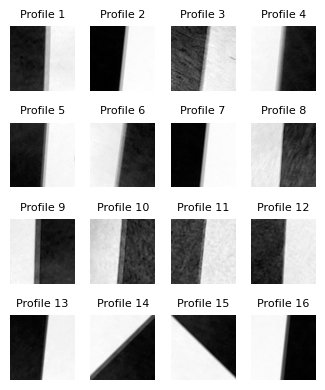

In [196]:
fig, ax = plt.subplots(4, 4, figsize = (12, 4), tight_layout = True)
plt.subplots_adjust(wspace = -1.0)
ax = ax.flatten()

for i, edge in enumerate(edge_profiles):
    ax[i].imshow(edge, cmap = "gray")
    ax[i].set_title("Profile {}".format(i+1), fontsize = 8)
    ax[i].axis("off")

In [290]:
def set_aspect(ax_number):
    return np.diff(ax[ax_number].get_xlim())[0] / np.diff(ax[ax_number].get_ylim())[0]

In [311]:
def normalize(array):
    return (array - array.min()) / (array.max() - array.min())

In [494]:
def modulation_transfer_function(edge_profile, num_line_profile, dx = 40): # Compute MTF for every line
    fig, ax = plt.subplots(1, 5, figsize = (16, 8), constrained_layout = True)
    # Choose random numbers within the shape of image to determine the profile of line
    random_rows = random.sample(range(0, np.shape(edge_profile)[0]), num_line_profile)
    mtf_vals_all_profs = []
    
    for i, row in enumerate(random_rows):
        # Sketch the profile of a line crossing edge
        start, end = (row, 0), (row, np.shape(edge_profile)[0] - 1)
        # line_profile = skimage.measure.profile_line(edge_profile, start, end)

        # Show the line of edge profile
        ax[0].imshow(edge_profile, cmap = "gray")
        ax[0].plot([start[1], end[1]], [start[0], end[0]], color = "red")
        ax[0].set_title("Sample edge profile")
        ax[0].axis("off")
        
        # Compute linespread function
        intensity_profile = edge_profile[row,:]
        pixel_vals = np.arange(0, np.shape(edge_profile)[0])
        pixel_vals_mm = pixel_vals / dx
        linespread_func = np.gradient(intensity_profile, pixel_vals_mm)
        ax[1].plot(intensity_profile)
        ax[1].set(title = "Intensity profile", xlabel = "Pixel value")
        ax[2].plot(linespread_func)
        ax[2].set(title = "Linespread function", xlabel = "Pixel value")
        
        # Compute the MTF
        pixel_vals_freq = np.fft.fftshift(np.fft.fftfreq(len(pixel_vals_mm), d = 1 / dx))
        pixel_vals_freq_pos = np.where(pixel_vals_freq >= 0)
        pixel_vals_freq_clipped = pixel_vals_freq[pixel_vals_freq_pos]
        mtf = abs(np.fft.fftshift(np.fft.fft(linespread_func)))
        ax[3].plot(pixel_vals_freq_clipped, normalize(mtf)[pixel_vals_freq_pos])
        ax[3].set(title = "Modulation transfer function", xlabel = "Spatial frequency (lp/mm)")
        mtf_vals_all_profs.append(normalize(mtf)[pixel_vals_freq_pos])
        
    # Get the average MTF and camera resolution
    average_mtf = np.array(sum(mtf_vals_all_profs)) / num_line_profile
    camera_mtf = np.where(np.around(average_mtf, decimals = 1) == 0.5)
    camera_res = pixel_vals_freq_clipped[camera_mtf[0][0]] # resolution where MTF = 0.5, in line/mm
    ax[4].plot(pixel_vals_freq[pixel_vals_freq_pos], average_mtf, zorder = -1, color = "blue", label = "Average MTF")
    ax[4].scatter(camera_res, 0.5, color = "red")
    ax[4].set(title = "Resolution = {:.1f} lp/mm".format(camera_res), xlabel = "Spatial frequency (lp/mm)")
    ax[4].legend()
        
    # Fix aspect ratios of plots
    for i in range(1, 5):
        aspect_ratio = np.diff(ax[i].get_xlim())[0] / np.diff(ax[i].get_ylim())[0]
        ax[i].set_aspect(aspect_ratio)

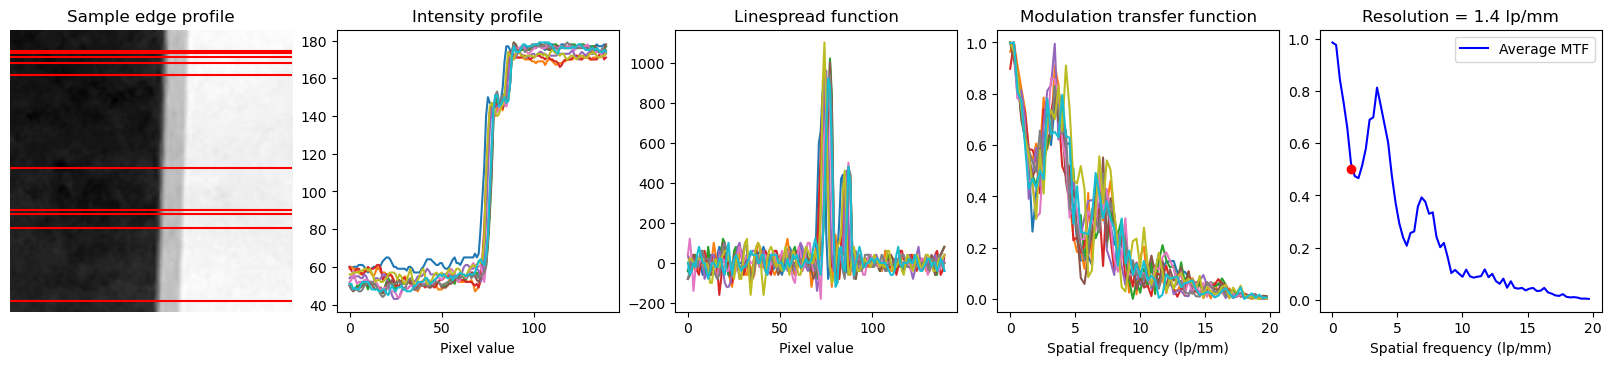

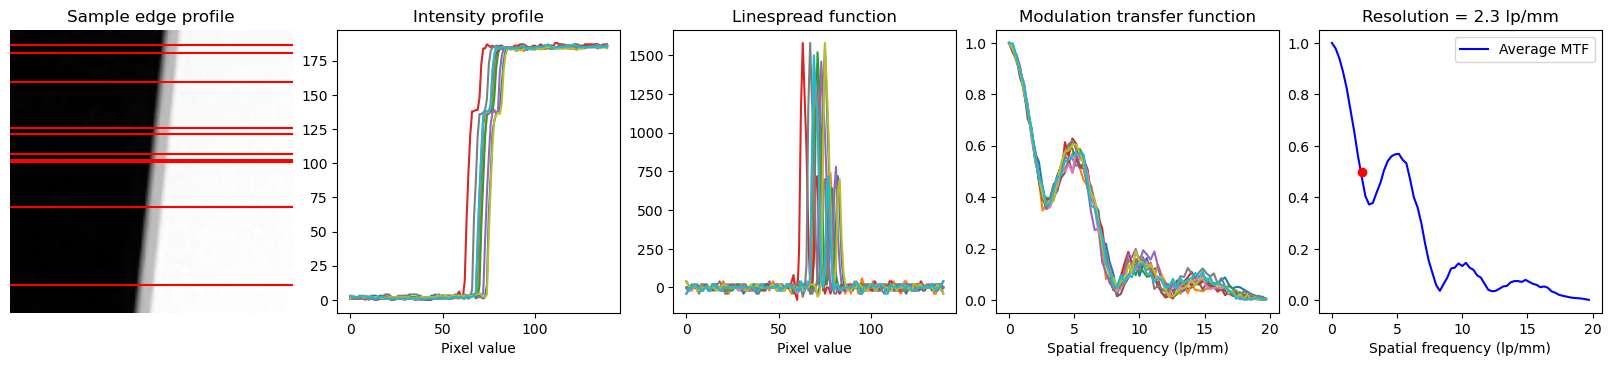

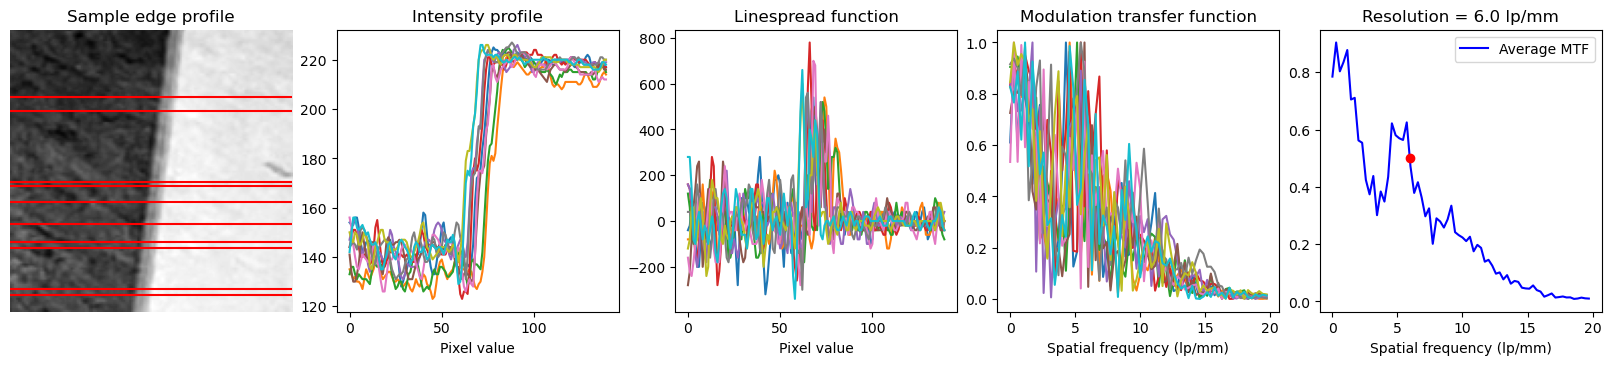

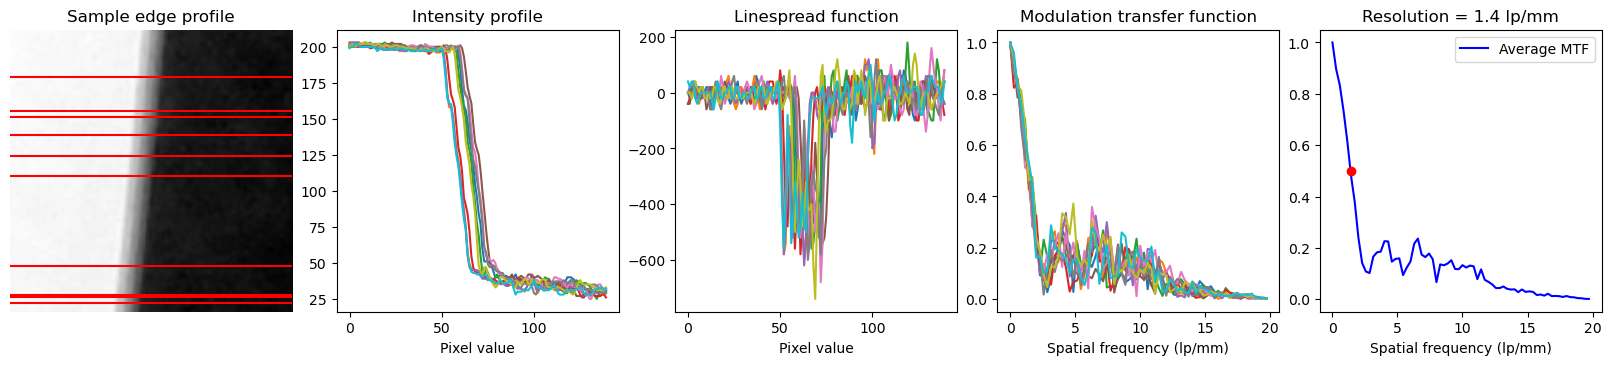

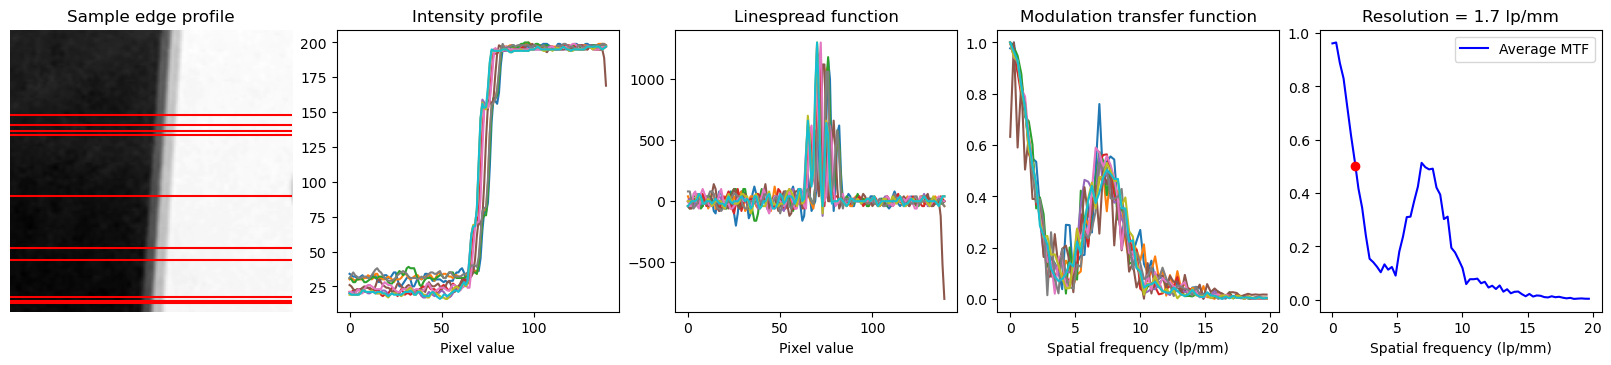

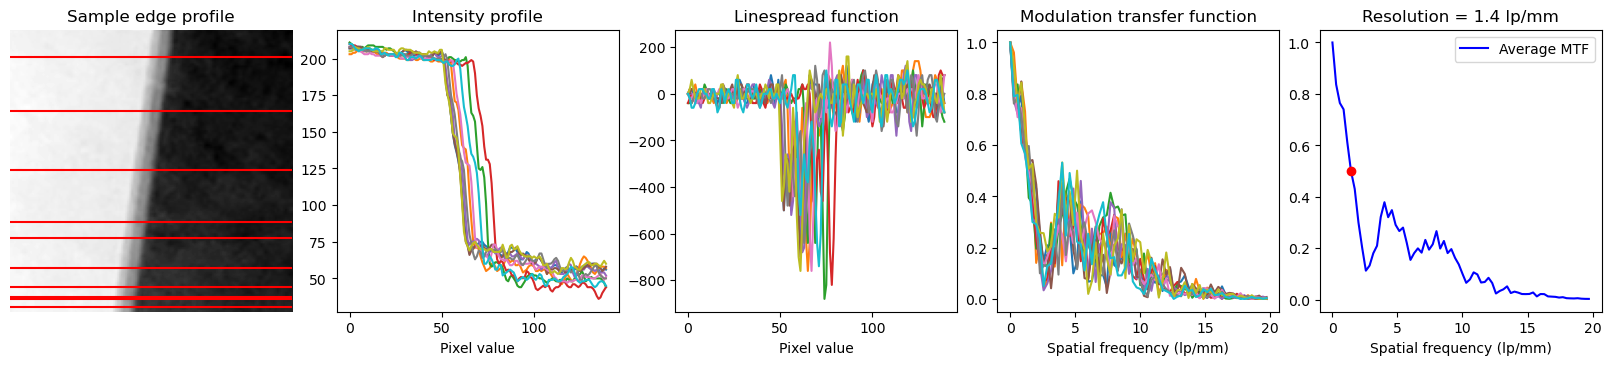

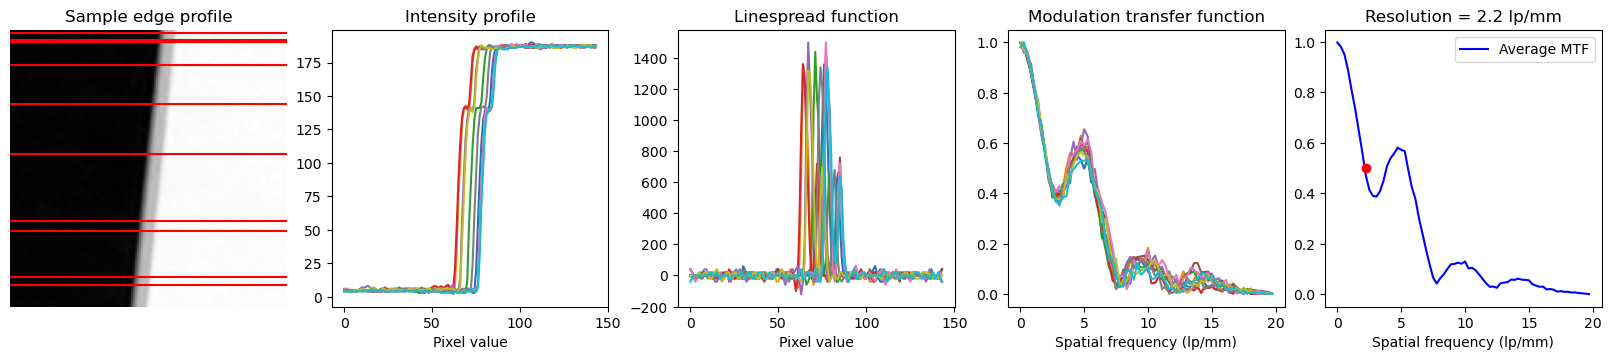

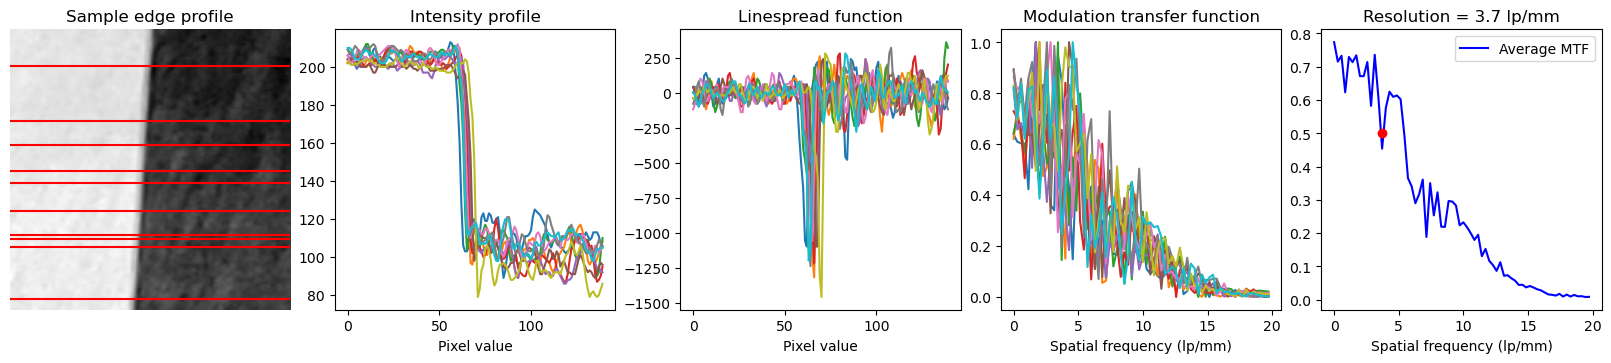

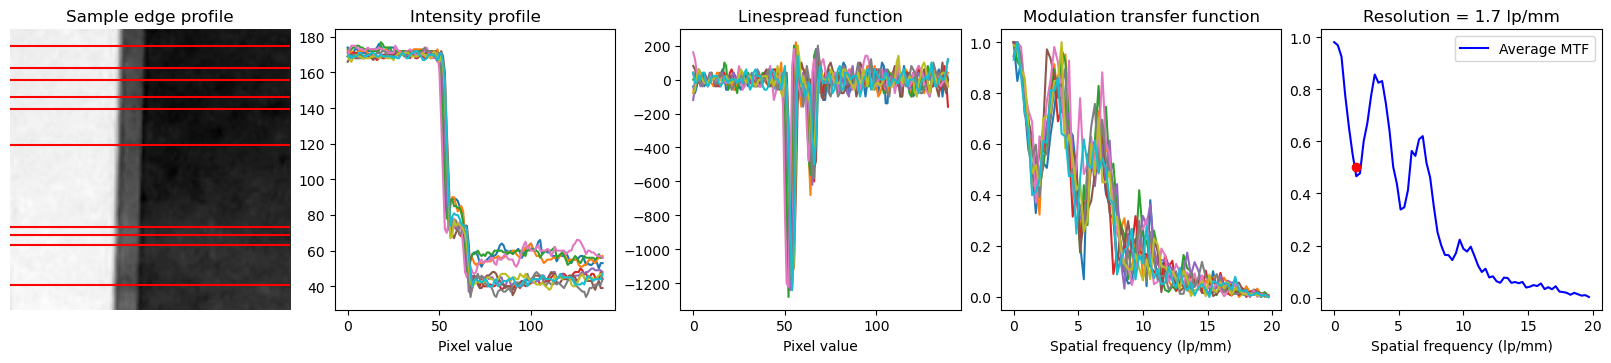

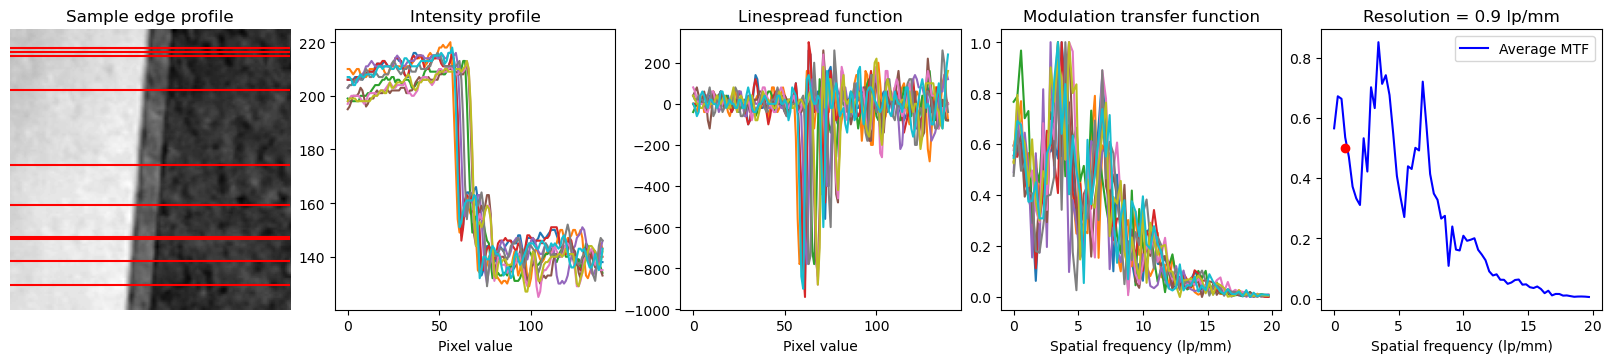

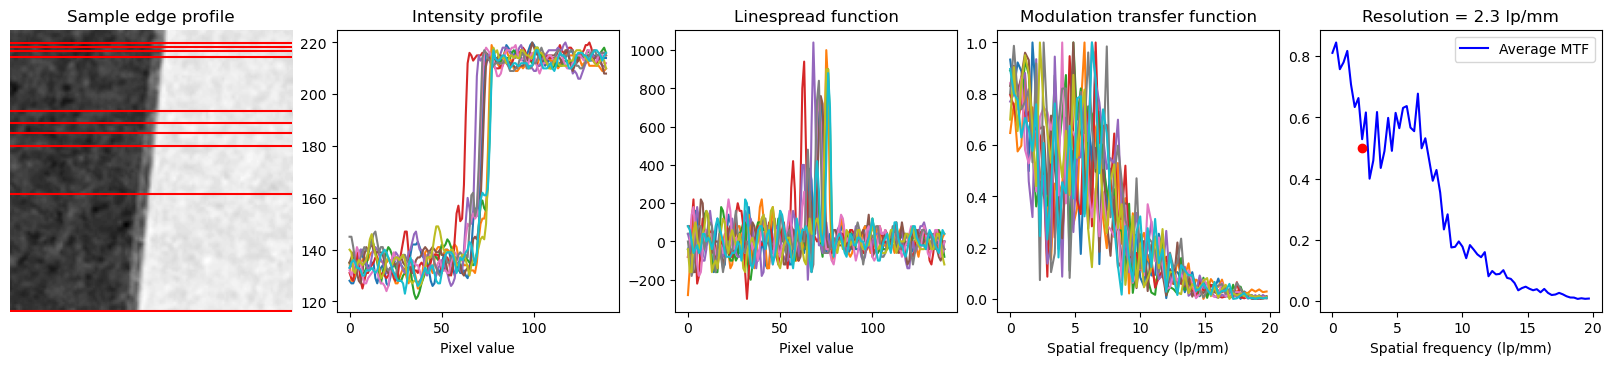

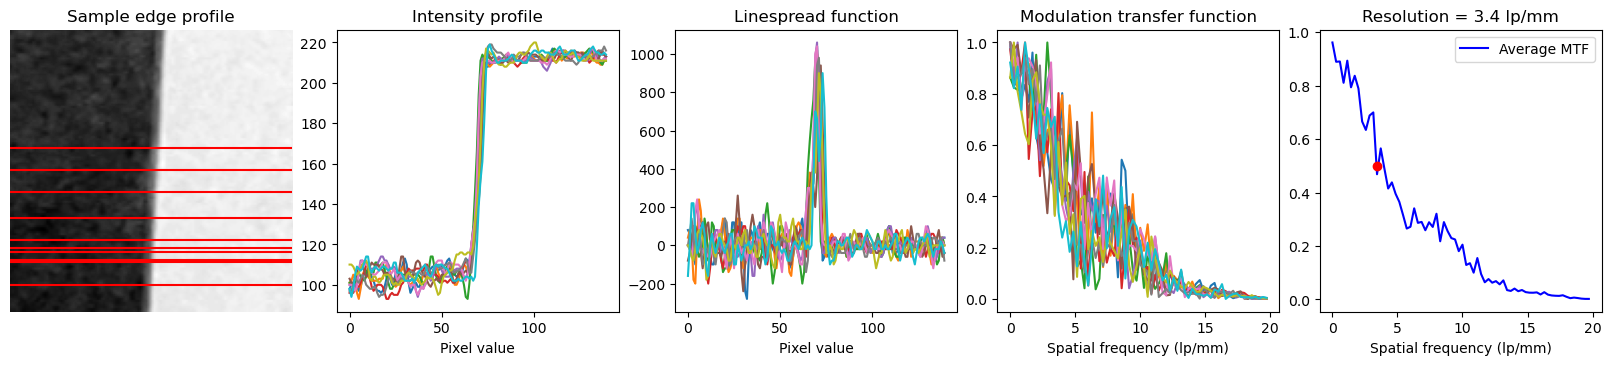

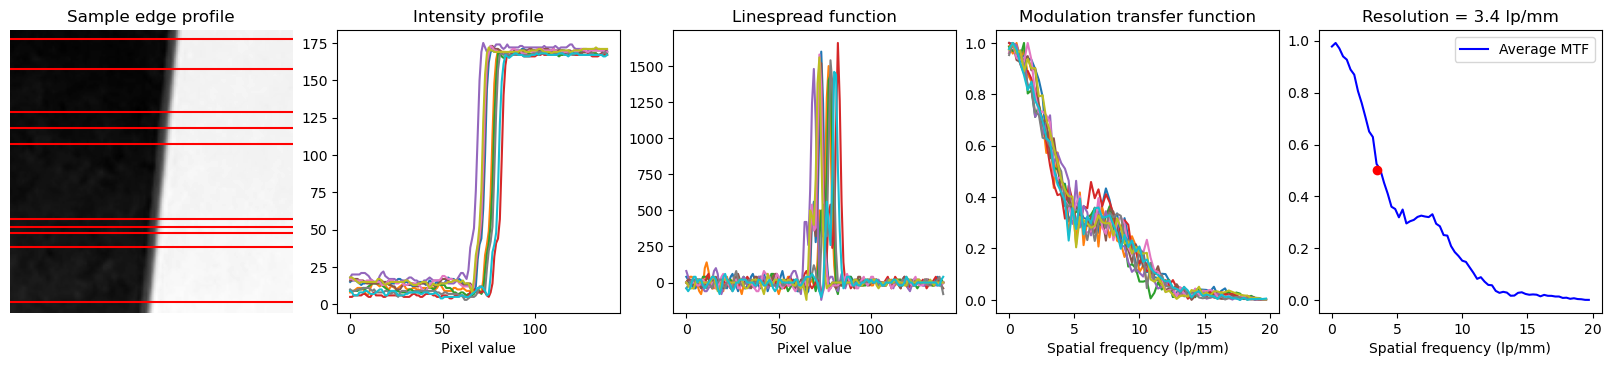

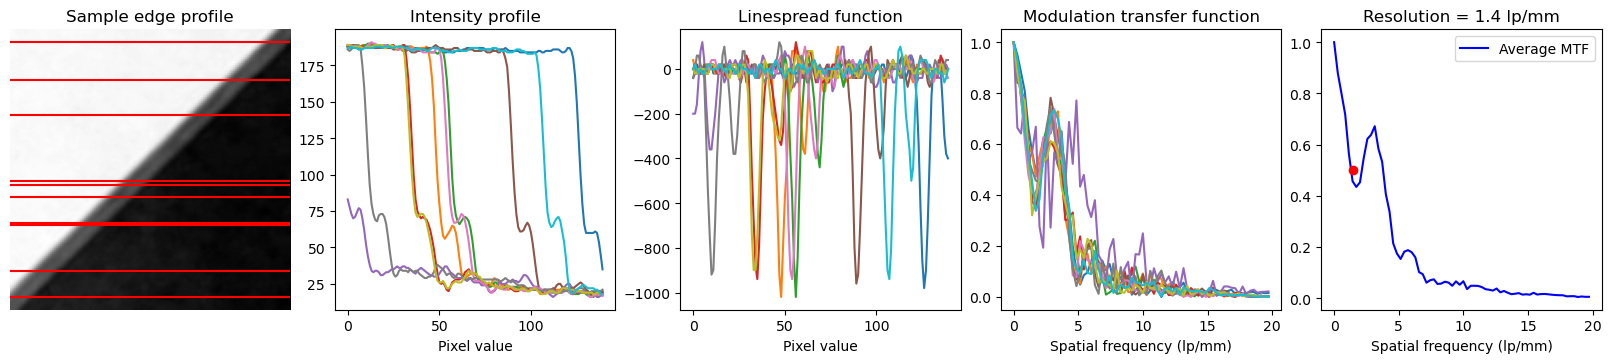

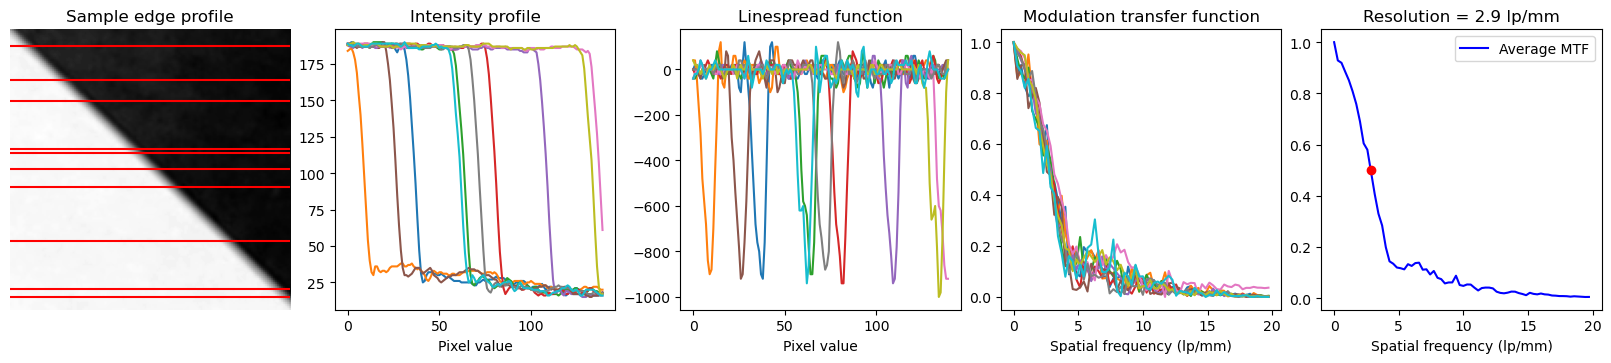

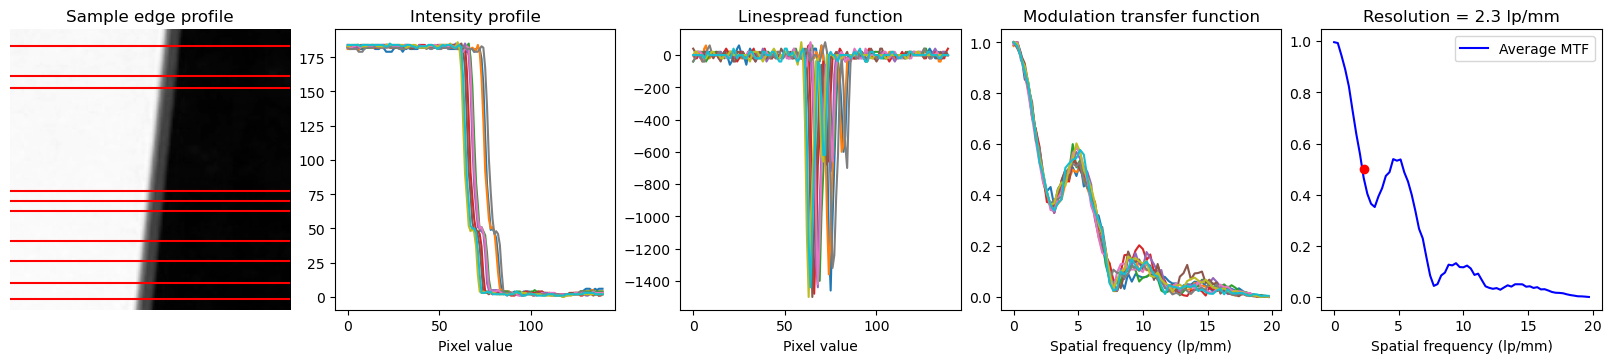

In [497]:
for i in range(np.shape(edge_profiles)[0]):
    modulation_transfer_function(edge_profiles[i], 10)

In [184]:
x_vals_freq = np.fft.fftshift(np.fft.fftfreq(len(x_vals_mm), d = 1 / 40))

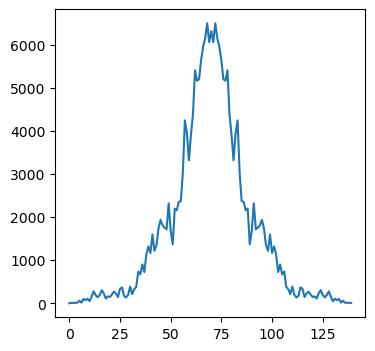

In [186]:
plt.plot(abs(np.fft.fftshift(np.fft.fft(deriv_edge_profile))))

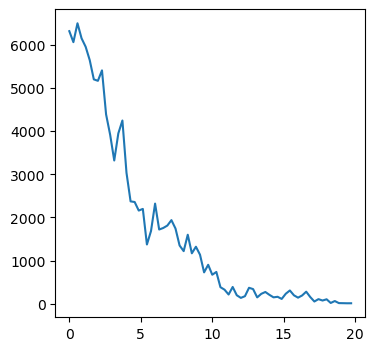

In [189]:
plt.plot(x_vals_freq[x_vals_freq >= 0], abs(np.fft.fftshift(np.fft.fft(deriv_edge_profile)))[x_vals_freq >= 0])

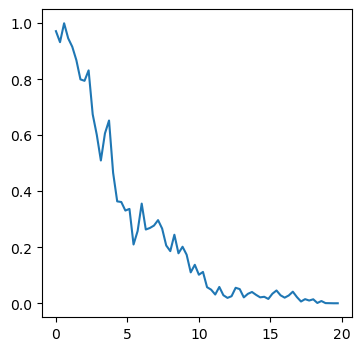

In [193]:
plt.plot(x_vals_freq[x_vals_freq >= 0], normalize(abs(np.fft.fftshift(np.fft.fft(deriv_edge_profile)))[x_vals_freq >= 0]))